In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [3]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets list -s covid-1
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 734M/745M [00:05<00:00, 99.6MB/s]
100% 745M/745M [00:05<00:00, 139MB/s] 


In [ ]:
!unzip -o /content/covid19-radiography-database.zip -d /content/ &> /dev/null

In [ ]:
# Set Path and Classes 

path = '/content/COVID-19_Radiography_Dataset'

classes=["COVID",  "Normal"]
num_classes = len(classes)
batch_size=32


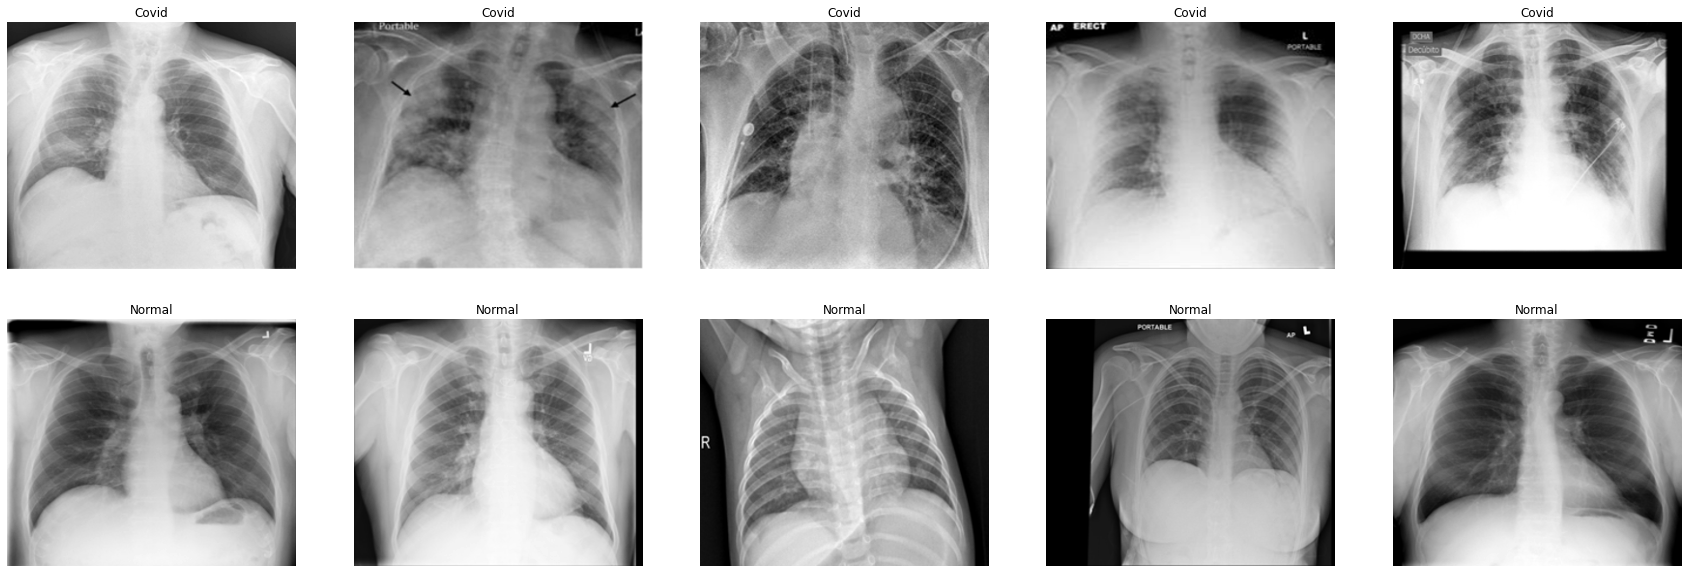

In [ ]:
# Plotting Images 

from os import listdir
from os.path import isfile
from os.path import join
Normal_path = '/content/COVID-19_Radiography_Dataset/Normal/'
Covid_path = '/content/COVID-19_Radiography_Dataset/COVID/'

Normal_Images_sample = [Normal_path+f for f in listdir(Normal_path) if isfile(join(Normal_path, f))][:5]
Covid_Images_sample = [Covid_path+f for f in listdir(Covid_path) if isfile(join(Covid_path, f))][:5]

samples = Covid_Images_sample + Normal_Images_sample 
del Normal_Images_sample, Covid_Images_sample

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Covid")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Create Training and Testing Batches
datagen = ImageDataGenerator(rotation_range=20, 
                             zoom_range=0.15, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.15, 
                             horizontal_flip=True, 
                             fill_mode="nearest", 
                             rescale=1./255, 
                             validation_split=0.2)

#load the images to training
train_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

#load the images for validation 

valid_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

#load the images to test
test_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")





Found 11047 images belonging to 2 classes.
Found 13808 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [ ]:
#get the class indices
train_gen.class_indices

{'COVID': 0, 'Normal': 1}

In [ ]:
#get the image shape
train_gen.image_shape

(299, 299, 1)

In [ ]:
model = Sequential()
# add the convolutional layer
# filters, size of filters,padding,activation_function,input_shape
model.add(Conv2D(32,(5,5),padding="SAME",activation="relu",input_shape=(299,299,3)))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# place a dropout layer
model.add(Dropout(0.5))
# add another convolutional layer
model.add(Conv2D(64,(5,5),padding="SAME",activation="relu"))

# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# place a dropout layer
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())
# add a dense layer : amount of nodes, activation
model.add(Dense(256,activation='relu'))
# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 299, 299, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 64)      51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350464)           

In [ ]:
#compile the model
model.compile(Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [2]:
# train the model
history = model.fit(train_gen,
                    epochs = 10,
                    validation_data = validation_generator)

In [ ]:
# Check test accuracy 
# get the test acuarcy and loss
test_loss, test_acc = model.evaluate(test_generator)
print('test loss:{} test acc:{}'.format(test_loss,test_acc))